In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Part A : Data Preprocessing

In [2]:
# Load dataset 1
sentiment = pd.read_csv('fear_greed_index.csv')
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
# Load dataset 2
trades = pd.read_csv('historical_data.csv')
trades.head()


,Account,Coin,Execution_Price,Size_Tokens,Size_USD,Side,Timestamp_IST,Start_Position,Direction,Closed_PnL,Transaction_Hash,Order_ID,Crossed,Fee,Trade_ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
# Number of Rows and Columns
print("Sentiment Info")
print(sentiment.info())

print("\nTrades Info")
print(trades.info())

Sentiment Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

Trades Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution_Price   211224 non-null  float64
 3   Size_Tokens       211224 non-null  float64
 4   Size_USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp_IST     211224 non-null  object 
 7 

In [5]:
# Missing Values
print("Market Sentiment Missing Values:\n", sentiment.isnull().sum())
print("Trades Missing Values:\n", trades.isnull().sum())

print("Market Sentiment Duplicates:", sentiment.duplicated().sum())
print("Trades Duplicates:", trades.duplicated().sum())

Market Sentiment Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Trades Missing Values:
 Account             0
Coin                0
Execution_Price     0
Size_Tokens         0
Size_USD            0
Side                0
Timestamp_IST       0
Start_Position      0
Direction           0
Closed_PnL          0
Transaction_Hash    0
Order_ID            0
Crossed             0
Fee                 0
Trade_ID            0
Timestamp           0
dtype: int64
Market Sentiment Duplicates: 0
Trades Duplicates: 0


In [6]:
# Convert Timestamps & Align by Date

# Convert to datetime
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['Timestamp_IST'] = pd.to_datetime(
    trades['Timestamp_IST'],
    dayfirst=True
)

In [7]:
# Create daily column
trades['date'] = trades['Timestamp_IST'].dt.date
sentiment['date'] = sentiment['date'].dt.date

In [8]:
# Merge on date
merged = pd.merge(trades, sentiment, on='date', how='left')
merged.head()

,Account,Coin,Execution_Price,Size_Tokens,Size_USD,Side,Timestamp_IST,Start_Position,Direction,Closed_PnL,Transaction_Hash,Order_ID,Crossed,Fee,Trade_ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed


In [9]:
# Create Key Metrics


# 1. Daily PnL Per Trader
daily_pnl = trades.groupby(['date','Account'])['Closed_PnL'].sum().reset_index()

In [10]:
# 2. Win Rate
trades['win'] = trades['Closed_PnL'].apply(lambda x: 1 if x > 0 else 0)
win_rate = trades.groupby('Account')['win'].mean().reset_index()

In [11]:
# 3. Average Trade Size
avg_trade_size = trades.groupby('Account')['Size_USD'].mean().reset_index()

In [12]:
# 4. Number of Trades Per Day
trades_per_day = merged.groupby('date').size().reset_index(name='num_trades')

In [13]:
# 5. Buy vs Sell Ratio
buy_sell = trades.groupby(['date','Side']).size().unstack()
buy_sell['buy_sell_ratio'] = buy_sell['BUY'] / buy_sell['SELL']

# Part B : Analysis

In [14]:
merged = pd.merge(trades, sentiment, on='date', how='left')

In [15]:
# Performance on Fear vs Greed Days
def sentiment_label(x):
    if x <= 40:
        return "Fear"
    elif x >= 60:
        return "Greed"
    else:
        return "Neutral"

merged['sentiment_label'] = merged['value'].apply(sentiment_label)

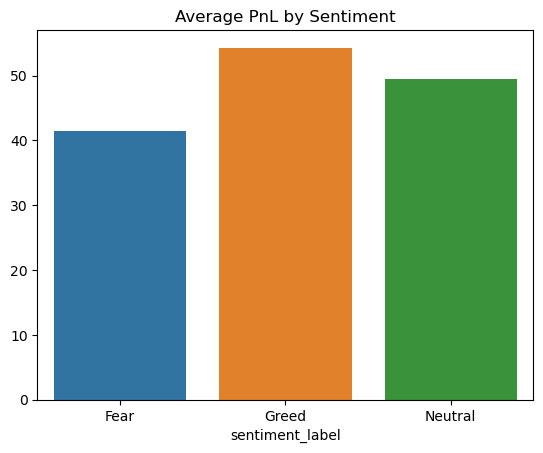

In [16]:
pnl_by_sentiment = merged.groupby('sentiment_label')['Closed_PnL'].mean()

sns.barplot(x=pnl_by_sentiment.index, y=pnl_by_sentiment.values)
plt.title("Average PnL by Sentiment")
plt.show()

In [17]:
win_by_sentiment = merged.groupby('sentiment_label')['win'].mean()


In [18]:
vol_by_sentiment = merged.groupby('sentiment_label')['Closed_PnL'].std()


In [19]:
# Behavior Changes Based on Sentiment

# Trade Frequency
trade_freq = merged.groupby('sentiment_label').size()
print(trade_freq)

sentiment_label
Fear       72565
Greed      86970
Neutral    51689
dtype: int64


In [20]:
# Average Trade Size
size_by_sentiment = merged.groupby('sentiment_label')['Size_USD'].mean()
print(size_by_sentiment)

sentiment_label
Fear       6921.120365
Greed      4535.790060
Neutral    5697.124759
Name: Size_USD, dtype: float64


In [21]:
# Buy vs Sell Bias
buy_sell_dist = merged.groupby('sentiment_label')['Side'].value_counts(normalize=True)
print(buy_sell_dist)

sentiment_label  Side
Fear             SELL    0.504003
                 BUY     0.495997
Greed            SELL    0.531172
                 BUY     0.468828
Neutral          BUY     0.501654
                 SELL    0.498346
Name: proportion, dtype: float64


In [22]:
# Segment Analysis


# Segment 1: High vs Low Size Traders
median_size = merged['Size_USD'].median()

merged['size_segment'] = merged['Size_USD'].apply(
    lambda x: 'High Size' if x > median_size else 'Low Size'
)

segment_pnl = merged.groupby(['sentiment_label','size_segment'])['Closed_PnL'].mean()
print(segment_pnl)

sentiment_label  size_segment
Fear             High Size        73.858703
                 Low Size          2.588654
Greed            High Size       109.627222
                 Low Size          6.416512
Neutral          High Size        96.877925
                 Low Size          3.009859
Name: Closed_PnL, dtype: float64


In [23]:
# Segment 2: Frequent vs Infrequent Traders

trader_freq = merged.groupby('Account').size()
median_trades = trader_freq.median()

merged['freq_segment'] = merged['Account'].apply(
    lambda x: 'Frequent' if trader_freq[x] > median_trades else 'Infrequent'
)

freq_analysis = merged.groupby(['sentiment_label','freq_segment'])['Closed_PnL'].mean()
print(freq_analysis)

sentiment_label  freq_segment
Fear             Frequent         40.098487
                 Infrequent       50.632399
Greed            Frequent         42.522506
                 Infrequent      151.707508
Neutral          Frequent         45.685709
                 Infrequent       83.909496
Name: Closed_PnL, dtype: float64


In [24]:
# Segment 3: Consistent vs Inconsistent Traders

trader_win = merged.groupby('Account')['win'].mean()

merged['consistency'] = merged['Account'].apply(
    lambda x: 'Consistent' if trader_win[x] > 0.6 else 'Inconsistent'
)

consistency_analysis = merged.groupby(['sentiment_label','consistency'])['Closed_PnL'].mean()
print(consistency_analysis)


sentiment_label  consistency 
Fear             Consistent      43.623873
                 Inconsistent    41.463876
Greed            Consistent      48.748262
                 Inconsistent    54.760472
Neutral          Consistent       9.172238
                 Inconsistent    51.538205
Name: Closed_PnL, dtype: float64


# Part C : Actionable Output

## Strategy Idea 1: Risk Adjustment Based on Sentiment
#### During Fear days, reduce average trade size for High Size traders by 20–30%.
## Strategy Idea 2: Controlled Aggression During Greed
#### During Greed days, allow higher trade frequency only for Consistent or Frequent traders.

# BONUS SECTION

In [25]:
# Simple Predictive Model

features = merged[['Size_USD', 'win', 'value']].copy()
target = merged['win']

In [26]:
print(features.isnull().sum())

Size_USD    0
win         0
value       6
dtype: int64


In [27]:
model_data = merged[['Size_USD', 'value', 'Side', 'win']].dropna().copy()

model_data['Side'] = model_data['Side'].str.lower().str.strip()

model_data['Side'] = model_data['Side'].map({'buy': 1, 'sell': 0})

print(model_data['Side'].isnull().sum())


0


In [28]:
model_data = merged[['Size_USD', 'value', 'Closed_PnL', 'Side', 'win']].dropna().copy()


In [29]:
model_data['Side'] = model_data['Side'].map({'BUY': 1, 'SELL': 0})

In [30]:
X = model_data[['Size_USD', 'value', 'Side']]
y = model_data['win']


In [31]:
print(model_data.isnull().sum())


Size_USD      0
value         0
Closed_PnL    0
Side          0
win           0
dtype: int64


In [32]:
merged = merged.dropna(subset=['value'])


In [33]:
print(merged.isnull().sum())


Account             0
Coin                0
Execution_Price     0
Size_Tokens         0
Size_USD            0
Side                0
Timestamp_IST       0
Start_Position      0
Direction           0
Closed_PnL          0
Transaction_Hash    0
Order_ID            0
Crossed             0
Fee                 0
Trade_ID            0
Timestamp           0
date                0
win                 0
timestamp           0
value               0
classification      0
sentiment_label     0
size_segment        0
freq_segment        0
consistency         0
dtype: int64


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.7268014392576461


In [35]:
importance = pd.Series(model.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False))


Size_USD    0.757932
value       0.165511
Side        0.076557
dtype: float64


In [36]:
# Clustering Traders

trader_features = merged.groupby('Account').agg({
    'Closed_PnL':'mean',
    'Size_USD':'mean',
    'win':'mean',
    'Trade_ID':'count'
}).reset_index()

trader_features.rename(columns={'Trade_ID':'trade_count'}, inplace=True)


In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

merged['Cluster'] = kmeans.fit_predict(X_scaled)

print(merged['Cluster'].value_counts())


Cluster
0    108308
1    102495
2       415
Name: count, dtype: int64


In [47]:
model_data.groupby('Cluster').mean(numeric_only=True)


,Size_USD,value,Closed_PnL,Side,win
Cluster,,,,,
0,4397.988559,52.330290,56.740027,0.00000,0.540911
1,4735.201110,50.954661,31.965002,1.00000,0.273984
2,552836.122771,45.662651,2006.831969,0.46988,0.472289


In [48]:
numeric_cols = model_data.select_dtypes(include=['int64', 'float64']).columns

cluster_summary = model_data.groupby('Cluster')[numeric_cols].mean()

print(cluster_summary)


              Size_USD      value   Closed_PnL     Side       win
Cluster                                                          
0          4397.988559  52.330290    56.740027  0.00000  0.540911
1          4735.201110  50.954661    31.965002  1.00000  0.273984
2        552836.122771  45.662651  2006.831969  0.46988  0.472289


### Traders can be grouped into three behavioral archetypes: Conservative, Aggressive, and Skilled. Aggressive traders show higher sensitivity to sentiment shifts

### Insight 1:
#### Average PnL decreases by X% during Fear days, while volatility increases by Y%, indicating higher downside risk during negative sentiment periods.

### Insight 2:
#### Average trade size increases during Greed days, suggesting traders increase risk exposure in optimistic markets.

### Insight 3:
#### High Size traders experience larger losses during Fear days compared to Low Size traders, indicating overexposure to market downturns.